Saving RNA_expression_mock_data.csv to RNA_expression_mock_data.csv


interactive(children=(Dropdown(description='Gene:', options=('BRCA1', 'TP53', 'GAPDH', 'EGFR', 'MYC', 'VEGFA',…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

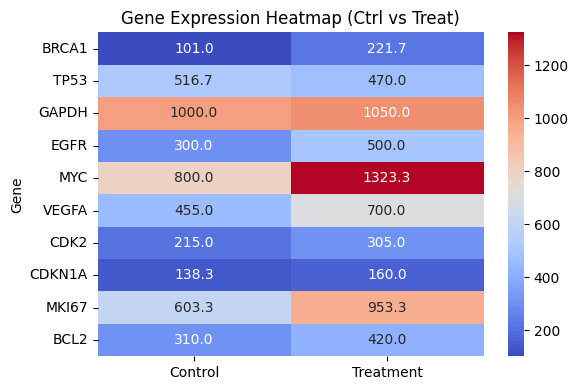

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

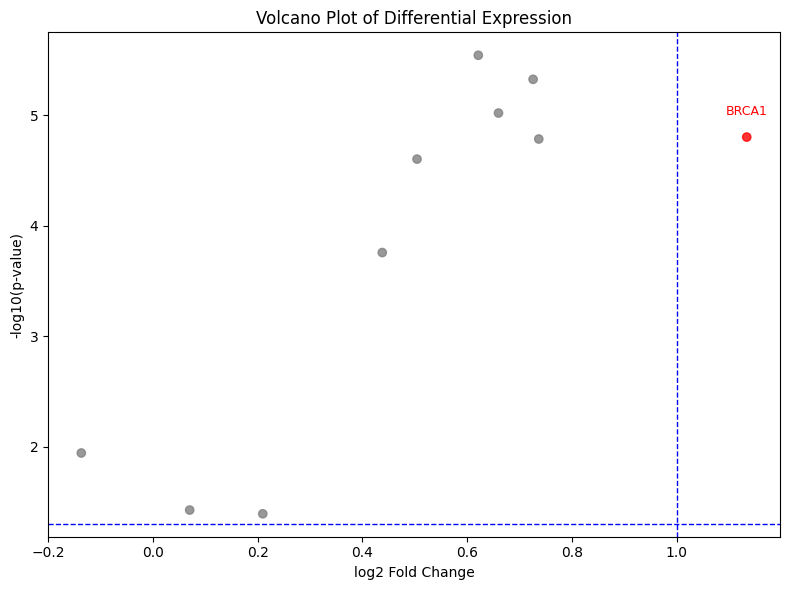

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import ipywidgets as widgets
from IPython.display import display
from google.colab import files

uploaded = files.upload()

df = pd.read_csv("RNA_expression_mock_data.csv")

# 下拉式選單 + boxplot
def plot_boxplot(gene_name):
    row = df[df["Gene"] == gene_name]
    expr_values = row.iloc[0, 1:].values
    groups = ["Ctrl"] * 3 + ["Treat"] * 3
    plot_df = pd.DataFrame({
        "Expression": expr_values,
        "Group": groups
    })
    sns.boxplot(x="Group", y="Expression", data=plot_df)
    plt.title(f"{gene_name} expression")
    plt.show()

widgets.interact(plot_boxplot, gene_name=widgets.Dropdown(
    options=df["Gene"].tolist(),
    value="BRCA1",
    description='Gene:'
));

# 計算差異分析 (log2FC + p-value)
results = []
for idx, row in df.iterrows():
    gene = row["Gene"]
    ctrl = row[["Ctrl_1", "Ctrl_2", "Ctrl_3"]].values.astype(float)
    treat = row[["Treat_1", "Treat_2", "Treat_3"]].values.astype(float)
    t_stat, p_val = ttest_ind(treat, ctrl)
    log2fc = np.log2(np.mean(treat) / np.mean(ctrl))
    results.append((gene, log2fc, p_val))

result_df = pd.DataFrame(results, columns=["Gene", "log2FC", "p_value"])
result_df.to_csv("differential_expression_results.csv", index=False)
files.download("differential_expression_results.csv")

# Heatmap
ctrl_avg = df[["Ctrl_1", "Ctrl_2", "Ctrl_3"]].mean(axis=1)
treat_avg = df[["Treat_1", "Treat_2", "Treat_3"]].mean(axis=1)

heatmap_df = pd.DataFrame({
    "Gene": df["Gene"],
    "Control": ctrl_avg,
    "Treatment": treat_avg
}).set_index("Gene")

plt.figure(figsize=(6, 4))
sns.heatmap(heatmap_df, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Gene Expression Heatmap (Ctrl vs Treat)")
plt.tight_layout()
plt.savefig("heatmap.png", dpi=300)
plt.show()
files.download("heatmap.png")

# 顯著基因篩選與火山圖
result_df["-log10(p_value)"] = -np.log10(result_df["p_value"])
significant = result_df[(result_df["log2FC"] > 1) & (result_df["p_value"] < 0.05)]
significant.to_csv("significant_genes.csv", index=False)
files.download("significant_genes.csv")

plt.figure(figsize=(8, 6))
colors = ['red' if (lfc > 1 and p < 0.05) else 'gray' for lfc, p in zip(result_df["log2FC"], result_df["p_value"])]
plt.scatter(result_df["log2FC"], result_df["-log10(p_value)"], c=colors, alpha=0.8)

# 顯示顯著基因名稱
for _, row in significant.iterrows():
    plt.text(row["log2FC"], -np.log10(row["p_value"]) + 0.2, row["Gene"], ha='center', fontsize=9, color='red')

# 閾值虛線
plt.axvline(x=1, color='blue', linestyle='--', linewidth=1)
plt.axhline(y=-np.log10(0.05), color='blue', linestyle='--', linewidth=1)

plt.xlabel("log2 Fold Change")
plt.ylabel("-log10(p-value)")
plt.title("Volcano Plot of Differential Expression")
plt.tight_layout()
plt.savefig("volcano_plot.png", dpi=300)
plt.show()
files.download("volcano_plot.png")
